In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import scipy.integrate as spint
import jax.scipy.integrate as jspint
import matplotlib.pyplot as plt
import scipy as sp
import functools
import time
from jax.scipy.signal import convolve as spconvolve

seed = 1
key = jax.random.PRNGKey(seed)
#jax.devices()

This runs Newton's method to generate the m function, along a curve stepping from infinity to $xs$ through the upper half plane.

$F(m)=1$

Initialization is at $m_0$

$F(m) \approx F(m_0) + F'(m_0)*(m-m_0) = 1$

Now set 

$m = m_0 + \frac{1-F(m_0)}{F'(m_0)}$

We apply this to the MDE, i.e.

$F(m) = m + \frac{1}{d}\sum_{j=1}^v \frac{j^{-2\alpha}m}{j^{-2\alpha}m - z}$

$F'(m) 
= 1 + \frac{1}{d}\sum_{j=1}^v \frac{j^{-2\alpha}}{j^{-2\alpha}m - z}-\frac{j^{-4\alpha}m}{(j^{-2\alpha}m - z)^2}= 1 - \frac{1}{d}\sum_{j=1}^v \frac{j^{-2\alpha}z}{(j^{-2\alpha}m - z)^2}$

In [2]:
def jax_gen_m_batched(v,d, alpha, xs,
                eta = -6, 
                eta0 = 6.0, 
                etasteps=50,
                batches = 100,
                zbatch=1000):
    """Generate the powerlaw m by newton's method

    
    Parameters
    ----------
    v,d,alpha : floats
        parameters of the model
    xs : vector
        The vector of x-positions at which to estimate the spectrum.  Complex is also possible.
    eta : float
        Error tolerance

    Returns
    -------
    m_Lambda: vector
        m_Lambda evaluated at xs.
    """
    #if zbatch > 0:
    #    xsplit = jnp.split(xs,jnp.arange(1,len(xs)//zbatch,1)*zbatch)
    #    ms = jnp.concatenate( [jax_gen_m_batched(v,d,alpha,x,eta,eta0,etasteps,batches,zbatch=0) for x in xsplit] )
    #    return ms
    v=jnp.int32(v)
    d=jnp.complex64(d)
    xs=jnp.complex64(xs)
    xsplit = jnp.split(xs,jnp.arange(1,len(xs)//zbatch,1)*zbatch)
    

    #print("xs length = {}".format(len(xs)))

    js=jnp.arange(1,v+1,1,dtype=jnp.complex64)**(-2.0*alpha)
    jt=jnp.reshape(js,(batches,-1))
    onesjtslice=jnp.ones_like(jt)[0]

    def mup_single(m,z):
        m1 = m 
        F=m1
        Fprime=jnp.ones_like(m1,dtype=jnp.complex64)
        for j in range(batches):
            denom = (jnp.outer(jt[j],m1) - jnp.outer(onesjtslice,z))
            F += (1.0/d)*jnp.sum(jnp.outer(jt[j],m1)/denom,axis=0)
            Fprime -= (1.0/d)*jnp.sum(jnp.outer(jt[j],z)/(denom**2),axis=0)
        return (-F + 1.0)/Fprime + m1
        #return 0.1*jnp.where(mask, m1, newm1)+0.9*m1
        
#    mup_single = jax.jit(mup_single, static_argnums=(0,1))

    def mup_scanner(ms,z,x):
        #mups = lambda m : mup_single(m,z*1.0j+xs)
        return mup_single(ms,z*1.0j+x), False
    
    #mup_scanner = jax.jit(mup_scanner, static_argnums=(0,1))
    mup_scannerjit =  jax.jit(mup_scanner)

    etas = jnp.logspace(eta0,eta,num = etasteps)
    ms = jnp.concatenate( [jax.lax.scan(lambda m,z: mup_scannerjit(m,z,x),jnp.ones_like(x),etas)[0] for x in xsplit] )
    #ms, _ = jax.lax.scan(mup_scanner,jnp.ones_like(xs),etas)
        
    return ms

In [3]:
def jax_gen_F_limit_batched(v,d, alpha, beta, 
                err = -2, timeChecks = False,batches=100):
    """Generate the the limit loss of F

    
    Parameters
    ----------
    v,d,alpha,beta,gamma : floats
        parameters of the model. TUNED FOR alpha < 1/2.
    err : float
        Error tolerance, log scale
    timeChecks: bool
        Print times for each part

    Returns
    -------
    Volterra: vector
        values of the solution of the Volterra
    """

    eps = 10.0**(err)
    L = -eps*(d**(-2*alpha))
    R = eps*(d**(-2*alpha))
    
    xs = jnp.arange(L,R,(eps**2)*(d**(-2*alpha)))
    zs = xs + 1.0j*eps*(d**(-2*alpha))*jnp.sin( jnp.pi*(R-xs)/((R-L)))
    dzs = (1.0 + 1.0j*eps*(d**(-2*alpha))*jnp.cos( jnp.pi*(R-xs)/((R-L)))*(-jnp.pi*1.0/(R-L)))*(eps**2)*(d**(-2*alpha))

    if timeChecks:
        print("The number of points on the spectral curve is {}".format(len(xs)))

    eta = jnp.log10(eps**2*(d**(-2*alpha)))
    eta0 = 6
    etasteps = jnp.int32(40 -4*err+ 10*(2*alpha)*jnp.log(d))

    start=time.time()
    if timeChecks:
        print("Running the Newton generator with {} steps".format(etasteps))

    ms = jax_gen_m_batched(v,d,alpha,zs,eta,eta0,etasteps,batches)

    end = time.time()
    if timeChecks:
        print("Completed Newton in {} time".format(end-start) )
    start = end

    js=jnp.arange(1,v+1,1)**(-2.0*alpha)
    jbs=jnp.arange(1,v+1,1)**(-2.0*(alpha+beta))

    jt=jnp.reshape(js,(batches,-1))
    jbt=jnp.expand_dims(jnp.reshape(jbs,(batches,-1)),-1)
    onesjtslice=jnp.ones_like(jt)[0]

    Fmeasure = jnp.zeros_like(ms)
    for j in range(batches):
        Fmeasure += jnp.sum(jbt[j]/(jnp.outer(jt[j],ms) - jnp.outer(onesjtslice,zs + 1.0j*(10**eta))),axis=0)
    Fmeasure = Fmeasure * dzs / (jnp.pi)

    return jnp.imag(jnp.sum(Fmeasure))

In [4]:
def jax_gen_Volterra_batched_mk2(v,d, alpha, beta, gamma, iterations,
                err = -2, timeChecks = False, batches=100):
    """Generate the solution of the Volterra equation

    
    Parameters
    ----------
    v,d,alpha,beta,gamma : floats
        parameters of the model. TUNED FOR alpha < 1/2.
    iterations : int
        The number of iteratoions
    err : float
        Error tolerance, log scale
    timeChecks: bool
        Print times for each part

    Returns
    -------
    Volterra: vector
        values of the solution of the Volterra
    """

    eps = 10.0**(err)
    R = 1.5
    L = d**(-2*alpha) 
    xs = jnp.arange(L+eps*(d**(-2*alpha))/2.0,R-eps*(d**(-2*alpha))/2.0,eps*(d**(-2*alpha)))
    zs = xs + (eps**2)*(2.0*alpha)*1.0j*jnp.sin( jnp.pi*(R-xs)/(R-L))**(1.0+1.0/(2.0*alpha))
    if jnp.isnan(zs).any():
        raise Exception("Got a NAN in the zs: {}".format(zs) )
    dzs = (1.0 + (eps**2)*((2.0*alpha)*1.0j)*
    (jnp.sin( jnp.pi*(R-xs)/(R-L))**(1.0/(2.0*alpha))*jnp.cos( jnp.pi*(R-xs)/(R-L)))
    *((1.0+1.0/(2.0*alpha))*(jnp.pi/(R-L))))*(eps*(d**(-2*alpha)))
    if jnp.isnan(dzs).any():
        raise Exception("Got a NAN in the dzs: {}".format(dzs) )

    if timeChecks:
        print("The number of points on the spectral curve is {}".format(len(xs)))

    eta = jnp.log10(eps*(d**(-2*alpha)))
    eta0 = 6
    etasteps = jnp.int32(40 + 10*(2*alpha)*jnp.log(d))

    start=time.time()
    if timeChecks:
        print("Running the Newton generator with {} steps".format(etasteps))

    ms = jax_gen_m_batched(v,d,alpha,zs,eta,eta0,etasteps,batches)

    end = time.time()
    if timeChecks:
        print("Completed Newton in {} time".format(end-start) )
    start = end

    js=jnp.arange(1,v+1,1)**(-2.0*alpha)
    jbs=jnp.arange(1,v+1,1)**(-2.0*(alpha+beta))

    jt=jnp.reshape(js,(batches,-1))
    jbt=jnp.expand_dims(jnp.reshape(jbs,(batches,-1)),-1)
    onesjtslice=jnp.ones_like(jt)[0]

    Fmeasure = jnp.zeros_like(ms)
    Kmeasure = jnp.zeros_like(ms)

    for j in range(batches):
        Fmeasure += jnp.sum(jbt[j]/(jnp.outer(jt[j],ms) - jnp.outer(onesjtslice,zs + 1.0j*(10**eta))),axis=0)

    Kmeasure = (1-ms)*((zs + 1.0j*(10**eta)))*d    

    Fmeasure = Fmeasure * dzs / (jnp.pi)
    Kmeasure = (gamma**2)*Kmeasure * dzs / (jnp.pi)

#    Fmeasure = jnp.sum(jbs/(jnp.outer(js,ms) - jnp.outer(jnp.ones_like(js),zs + 1.0j*(10**eta))),axis=0)
#    Fmeasure = Fmeasure * dzs / (jnp.pi)

#    Kmeasure = jnp.sum(1.0/(jnp.outer(js,ms) - jnp.outer(jnp.ones_like(js),zs + 1.0j*(10**eta))),axis=0)*((zs + 1.0j*(10**eta))**2)
#    Kmeasure = (gamma**2)*Kmeasure * dzs / (jnp.pi)

    gdgenerator = -2.0*gamma*zs + (2.0*gamma**2)*(zs**2) + 1.0

    mmod = max(jnp.abs(gdgenerator))
    if timeChecks:
        print("The max modulus along the spectral curve is {}".format(mmod))

    batch = 100
    gdgenerator_batch =  jnp.power(jnp.outer(gdgenerator,jnp.ones(batch,dtype=jnp.complex64)), jnp.arange(0,batch,1))
    gdgenerator_step = jnp.expand_dims(
        jnp.power(gdgenerator,batch),1
    )
    Fs = []
    Ks = []
    #Fvals=jnp.zeros(iterations, dtype=jnp.complex64)
    
    for j in range(iterations//batch + 1):
        Fs.append(jnp.imag(jnp.tensordot(gdgenerator_batch,Fmeasure, axes=[[0],[0]])))
        Ks.append(jnp.imag(jnp.tensordot(gdgenerator_batch,Kmeasure, axes=[[0],[0]])))
        gdgenerator_batch = gdgenerator_batch * gdgenerator_step

    #GENERATE the LIMIT LOSS WITH EXTRA ORDER OF ACCURACY
    ylevel = jax_gen_F_limit_batched(v,d,alpha,beta,err-1.5,timeChecks,batches)

    F = jnp.concatenate(Fs)
    F_0 = ylevel
    K = jnp.concatenate(Ks)
    end = time.time()
    if timeChecks:
        print("Completed F/K generation in {} time".format(end-start) )
    start = end

    VolterraRuns = jnp.int32(40 - err*10)
    if timeChecks:
        print("Running Volterra FP for {} steps for F/K length {}".format(VolterraRuns,len(F)) )

    phi = F + F_0
    for j in range(VolterraRuns):
#        phi= F+jnp.convolve(phi,K, mode='full')[0:len(F)]
        phi= F + F_0 +spconvolve(phi,K, mode='full',method='fft')[0:len(F)]


    end = time.time()
    if timeChecks:
        print("Completed Volterra FP generation in {} time".format(end-start) )

    return F,K,phi


In [5]:
#FLOP_CONSTANT*(D**2alpha)/gamma_mult is the number of iterations run
FLOP_CONSTANT=200.0

#noise 0
eta = 0.0
#this will multiply the data-norm (sum on j of j^{-2alpha} from 1 to V) 
gamma_mult=0.25
#batch size
Batch=1

#VLIST=[20000,20000,20000,20000,20000,20000]
#DLIST=[300,500,800,1200,1800,2700]
#DLIST = [ 400, 800, 1600, 3200, 6400, 12800, 25600 ]
DLIST = [ 400, 800, 1600 ]

#DLIST=[100,200,400]

PHASES = [(0.40,1.0)] 

In [6]:
F_list = dict((phase,dict((key, []) for key in DLIST)) for phase in PHASES)
K_list = dict((phase,dict((key, []) for key in DLIST)) for phase in PHASES)
Volterra_list = dict((phase,dict((key, []) for key in DLIST)) for phase in PHASES)
v_list = dict((phase,dict((key, []) for key in DLIST)) for phase in PHASES)
gamma_list = dict((phase,dict((key, []) for key in DLIST)) for phase in PHASES)

#set all Vs to be used to be D*10
for p in PHASES:
  for D in DLIST:
    v_list[p][D]=D*10


In [7]:
PHASES_TO_RUN = PHASES

#PHASES_TO_RUN = [(0.15,0.33)]

for p in PHASES_TO_RUN:
  F_list[p] = dict((key, []) for key in DLIST)
  K_list[p] = dict((key, []) for key in DLIST)
  Volterra_list[p] = dict((key, []) for key in DLIST)

for (alpha,beta) in PHASES_TO_RUN:
  p=(alpha,beta)
  for D in DLIST:
    start=time.time()
    V=v_list[p][D]
    steps = np.int32( FLOP_CONSTANT* (D**(2*alpha))/gamma_mult)
    gamma = gamma_mult/jnp.sum(jnp.arange(1,V,1)**(-2.0*alpha))

    gamma_list[p][D] = gamma
    F,K,phi = jax_gen_Volterra_batched_mk2(V,D,alpha,beta,gamma,steps,err=-1.0,timeChecks=False,batches=D//80)

    F_list[p][D] = F
    K_list[p][D] = K
    Volterra_list[p][D] = phi

    end=time.time()
    print("Completed (D,a,b)=({},{},{}) in time: {}s".format(D,alpha,beta,end-start))
  


Completed (D,a,b)=(400,0.4,1.0) in time: 10.227702856063843s
Completed (D,a,b)=(800,0.4,1.0) in time: 28.856433868408203s
Completed (D,a,b)=(1600,0.4,1.0) in time: 94.26141691207886s


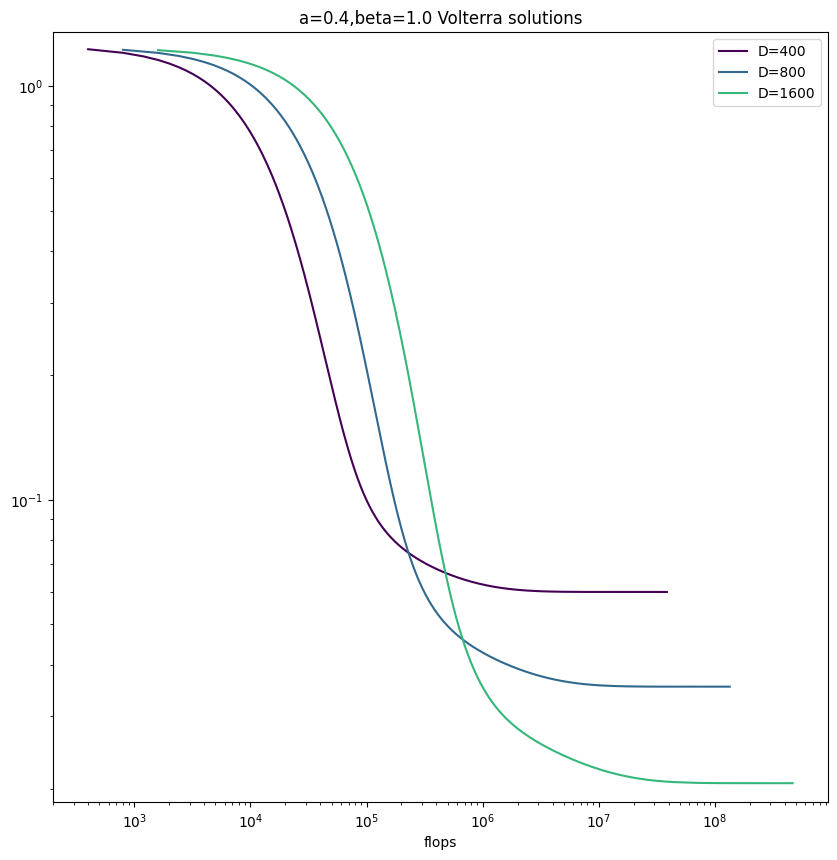

In [8]:
fig, axs = plt.subplots(1, 1, figsize=(10,10))
fig.subplots_adjust(hspace=0.4)
axs = np.reshape(axs,(1,))
cs= plt.colormaps["viridis"]

for p, (alpha,beta) in enumerate(PHASES):

  ylim_lower = 1.0
  ylim_upper = 1.0


  for i,D in enumerate(DLIST):
    ttimes=jnp.arange(1,len(F_list[(alpha,beta)][D])+1,1.0)*D
    #axs[p].plot(ttimes,F_list[(alpha,beta)][D],color=cs(i/len(DLIST), alpha=1.0), linestyle='dashed')
    axs[p].plot(ttimes,Volterra_list[(alpha,beta)][D],color=cs(i/len(DLIST), alpha=1.0), label='D={}'.format(D))
  
    #axs[p].plot(ttimes,K_list[(alpha,beta)][D],color=cs(i/len(DLIST), alpha=1.0), label='D={}'.format(D))
    #axs[p].plot(ttimes,K_list_mk2[(alpha,beta)][D],color=cs(i/len(DLIST), alpha=1.0), label='D={}'.format(D), linestyle='dashed')


    ylim_upper = max(ylim_upper, max(Volterra_list[(alpha,beta)][D]))
    ylim_lower = min(ylim_lower, min(Volterra_list[(alpha,beta)][D]))

    V = v_list[(alpha,beta)][D]
    h=jnp.sum(jnp.arange(1.0,V,1.0)**(-2.0*(alpha+beta)))
    #axs[p].plot(ttimes,jnp.ones_like(ttimes)*h,color=cs(i/len(DLIST), alpha=1.0), linestyle='dotted')

    gamma = gamma_list[(alpha,beta)][D] 
    #ylevel = tt_dbetacirc_VD(alpha,beta,V,D)
    #ylevel2 = jax_gen_F_limit(V,D,alpha,beta)
    #knorm = tt_knorm_limit(alpha,beta,V,D,gamma)
    #knorm2 = jnp.sum(K_list[(alpha,beta)][D])
    #axs[p].plot(ttimes,jnp.ones_like(ttimes)*ylevel2/(1.0-knorm2),color=cs(i/len(DLIST), alpha=1.0), linestyle='dashed')
    #axs[p].plot(ttimes,F_list[(alpha,beta)][D],color=cs(i/len(DLIST), alpha=1.0), linestyle='dashed')


  
plt.ylim((ylim_lower*0.9,ylim_upper*1.1))
plt.title("a={},beta={} Volterra solutions".format(alpha,beta))
plt.xlabel('flops')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.savefig("alphabetaVolterraOnly.pdf")